# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [4]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200

## Baseline of 0

In [5]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

## Repeat for different measurments

In [7]:
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)

In [8]:
langevin = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    langevin.append((sum(error)/len(error)).cpu().detach())

100%|██████████| 15/15 [01:21<00:00,  5.40s/it]


In [9]:
config["estimator_params"]["estimator"] = "map"
config["estimator_params"]["n"] = 15

In [10]:
map_est = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    map_est.append((sum(error)/len(error)).cpu().detach())

 40%|████      | 6/15 [00:30<00:45,  5.04s/it]

In [ ]:
len(list(range(0, 750, 50)))

15

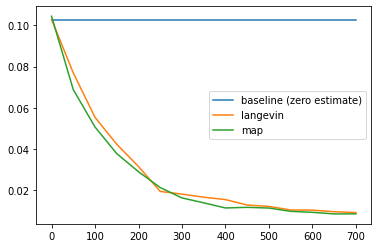

In [ ]:
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.plot(list(range(0, 750, 50)), langevin)
plt.plot(list(range(0, 750, 50)), map_est)
plt.legend(['baseline (zero estimate)','langevin', 'map'])
plt.show()